# Verification of generated Sequences

In this notebook we explore and verify our solution for the HLA-A gene.

## Section 1: Setup

In [1]:
from gentype import EnsemblClient, DataManager, PiCollapsedNonparametricGibbsSampler
from gentype import AlleleMM, get_distances
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np
import sys

Set up Classes:

In [2]:
Database_Name = "Gentype_DB.db"
client = EnsemblClient()
data_manager = DataManager(client, Database_Name)

Setting the paramaters for our selected allele: HLA-A. For options for ref_name and population_name you can also take a look at the database after fetching.

In [3]:
region_start = 29941260
region_end = 29945884
ref_name = "6" # generally the name of the chromosome
population_name = "ALL"
project_name = "1000GENOMES:phase_3"
allele_args = {'start' : region_start, 'end' : region_end, 'reference_name' : ref_name, 'population' : population_name, 'project' : project_name}

We use store magic to store the values of costly computations (data fetching, model training), so they only have to be done once.

Initialize storable data:

In [4]:
fetched = False
inference_matrix = None
eval_models = None

Restore stored data (remove # to recompute instead of restore respective data):

In [5]:
#%store -d fetched # if you want to refetch the data, uncomment this line
#%store -d inference_matrix # if you want to recompute the inference_matrix, uncomment this line
#%store -d eval_models # if you want to recompute the models, uncomment this line
%store -r

## Section 2: Collecting and preparing data

Fetches all HLA-A data obtained in 1000 Genomes project phase3 and stores them in a local sqlite server. This only needs to be done once but might take a while.

In [6]:
if not fetched:
    data_manager.fetch_all(region_start, region_end, ref_name, report_progress = True)
fetched = True
%store fetched

Stored 'fetched' (bool)


The following generates an inference matrix from the data provided by the local database. The inference matrix can be constructed with respect to a population and a section specified by start and end. Be sure to fetch the according population before constructing the matrix. 

Each row in the matrix represents the variants present in each individual as a bitvector.

In [7]:
if inference_matrix is None:
    inference_matrix, individual_map, variation_map = data_manager.generate_inference_matrix(**allele_args)
%store inference_matrix 
%store individual_map 
%store variation_map
inference_matrix.shape

Stored 'inference_matrix' (ndarray)
Stored 'individual_map' (dict)
Stored 'variation_map' (dict)


(5008, 438)

## Section 3: Splitting test and training Data

In order to verify our data, we split our known data into a test and training set.
We will verify our algorithm by comparing the generated data with know existing data which was not used to train the model. Thus we unconventionally choose an even split.

In [8]:
split_point = int(len(inference_matrix)/2)
# if we want to keep using our mapping we need to use the first half for training
inference_matrix_training = inference_matrix[:split_point]
inference_matrix_test = inference_matrix[split_point:]


In the PCA plot we can see that our training and test sets are fairly evenly distributed.

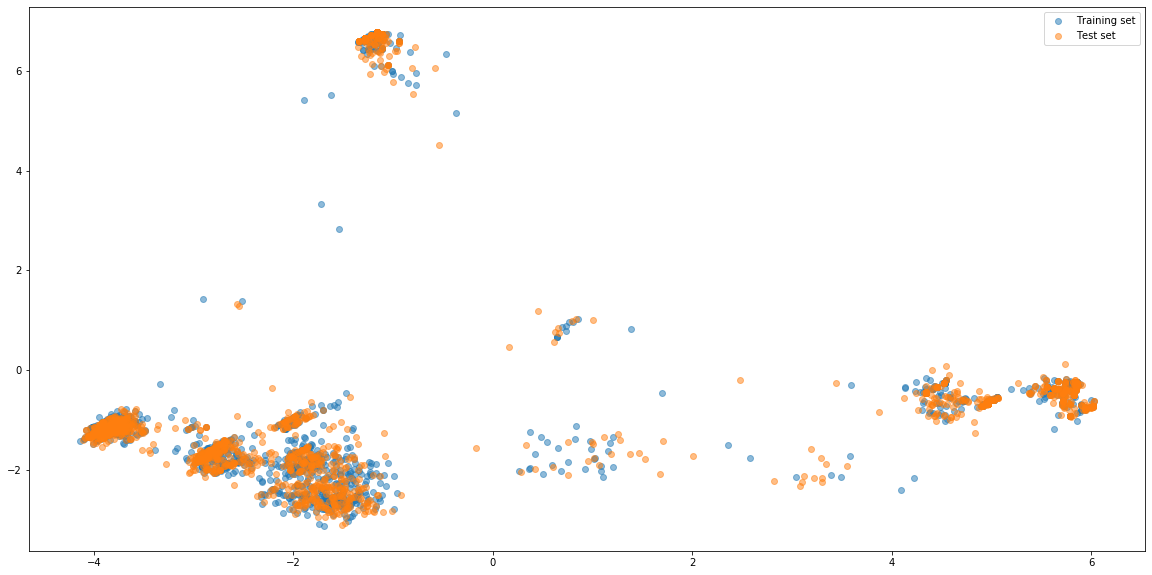

In [9]:
fig, ax = plt.subplots(figsize = (20,10))

pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(inference_matrix)
pca.explained_variance_ratio_.cumsum()
ax.plot(principalComponents[:split_point,0], principalComponents[:split_point,1], "o", alpha=0.5)
ax.plot(principalComponents[split_point:,0], principalComponents[split_point:,1], "o", alpha=0.5)
ax.legend(["Training set", "Test set"])

## Section 4: Training the Model

Train models with different initializations without seeding.

Here we compute different models with varying dirichlet prior alpha. This prior is proportional to the probability of creating a new cluster, therefore inference with high alphas tends to begin with a higher number of clusters. This might take a while.

Model 0 with 6.0 clusters:


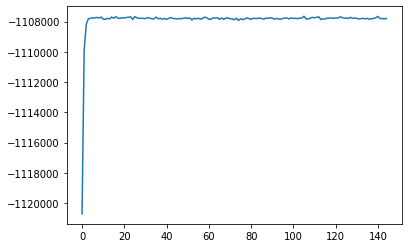

Model 1 with 7.0 clusters:


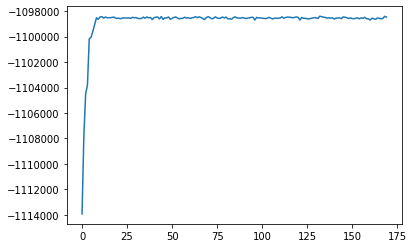

Model 2 with 9.0 clusters:


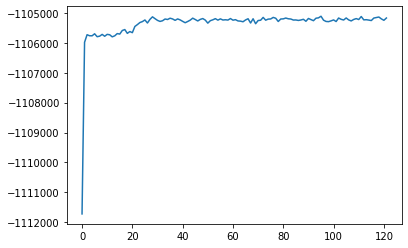

Stored 'eval_models' (list)


In [10]:
number_models = 3
if eval_models is None:
    eval_models = [PiCollapsedNonparametricGibbsSampler(42) for i in range(number_models)]
    for i in range(0, len(eval_models)):
        print("Model {}:".format(i))
        eval_models[i].fit(inference_matrix_training, num_burn_in_steps = 100, delta = 1, alpha = 10**(i - 1))
for i in range(0, len(eval_models)):
    print("Model {} with {} clusters:".format(i, max(eval_models[i].Z)))
    plt.clf()
    plt.plot(eval_models[i].ll_list)
    plt.show()

%store eval_models

May pre select models e.g. according to Aitikens Information Criterion (AIC).

In [11]:
def AIC(model):
    size = np.prod(np.shape(model.theta))
    loglikelihood =model.ll_list[-1]
    return 2*size - 2*loglikelihood
values = list(map(lambda x: AIC(x), eval_models))
print(values)
best_idx = values.index(min(values))
print("Chose model {}.".format(best_idx))

[2221734.949619845, 2203929.6730219023, 2219090.50733476]
Chose model 1.


## Section 5: Verifying the Generation

Generate a good amount of samples (the more the better, but also the longer it will take) and store additional information. Then compute the distance metrics.

In [12]:
variant_ranges = data_manager.get_variation_range(**allele_args)
mm = AlleleMM(eval_models[best_idx].Z, eval_models[best_idx].theta, inference_matrix_training, variant_ranges, variation_map)
number_of_samples = 100
samples = []
clusters = []
descriptions = []
for i in range(number_of_samples):
    characteristic_vector = np.zeros(len(eval_models[best_idx].theta[0]))
    sample, cluster = mm.sample_variations(return_cluster = True)
    characteristic_vector[sample] = 1
    samples.append(characteristic_vector)
    clusters.append(cluster)
assigned_distance, distribution_difference, assignments = get_distances(samples, inference_matrix_test, return_assignments = True)
print("Average assigned distances: {}\nDistribution difference: {}".format(sum(assigned_distance.values())/len(samples), distribution_difference))

Average assigned distances: 24.24
Distribution difference: 1.612204472843499


We can plot the distances for each sequence by the cluster they were generated by to gain further insight.

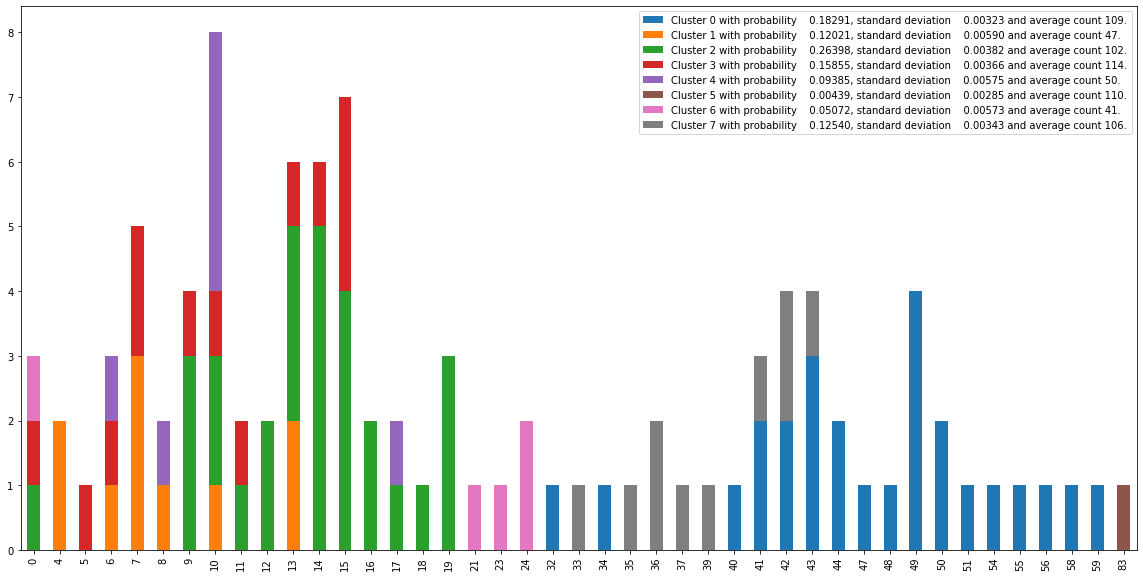

In [13]:
fig, ax = plt.subplots(figsize=(20,10))
assigned_distance_clusters = []
distances = set()
for i in range(mm.clusters):
    assigned_distance_clusters.append([])
for i, sample in enumerate(samples):
    assigned_distance_clusters[clusters[i]].append(assigned_distance[tuple(sample)])
    distances.add(assigned_distance[tuple(sample)])

distances = list(distances)
distances.sort()

cluster_per_distances = []
for distance in distances:
    cluster_per_distance = []
    for cluster in assigned_distance_clusters:
        cluster_per_distance.append(cluster.count(distance))
    cluster_per_distances.append(cluster_per_distance)
cluster_per_distances = np.array(cluster_per_distances)

standard_deviations = [np.std(mm.theta[i]) for i in range(mm.clusters)]
avg_count = []
for i in range(mm.clusters):
    choices, probabilites = mm.distributions[i]
    avg_count.append(int(sum(choice * prob for choice, prob in zip(choices, probabilites))))
descriptions = ["Cluster {} with probability {:10.5f}, standard deviation {:10.5f} and average count {}.".format(i, mm.pi[i], standard_deviations[i], avg_count[i]) for i in range(mm.clusters)]
df = pd.DataFrame(dict(zip(descriptions, cluster_per_distances.T)))
df.index = distances

df.plot(kind="bar", stacked=True, ax=ax)

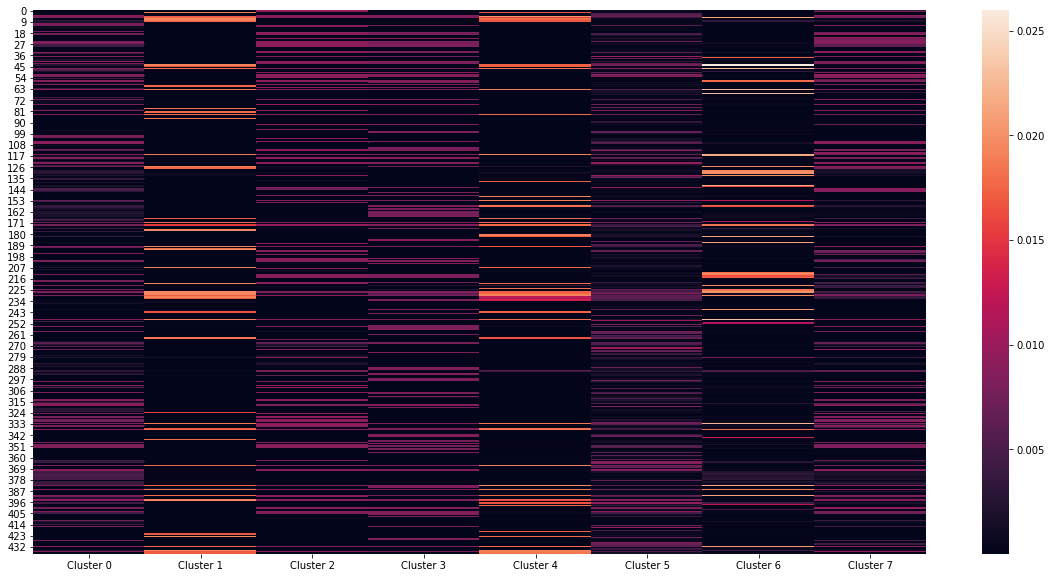

In [22]:
df = pd.DataFrame(dict(zip(["Cluster " + str(i) for i in range(len(eval_models[best_idx].theta))], list(eval_models[best_idx].theta))))
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.heatmap(df)

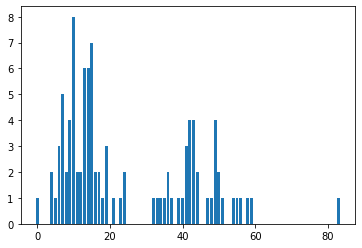

In [15]:
from collections import Counter
c = Counter(assigned_distance.values())
plt.bar(c.keys(), c.values())
plt.show()

In [16]:
cluster_diff_count = 0
seen = []
for i, row in enumerate(inference_matrix_training):
    if str(row) in seen: continue
    seen.append(str(row))
    for j, sample in enumerate(samples):
        if (assignments[tuple(sample)] == tuple(row)).all() and mm.Z[i] != clusters[j]:
            cluster_diff_count += 1
cluster_diff_count
        
    

2

In [17]:
def KL_div(p, q):
    return np.nan_to_num([p[i] * np.log(p[i]/q[i]) for i in range(len(p))]).sum()

In [18]:
null_model = inference_matrix_training.sum(axis=0)
null_model /= inference_matrix_training.sum()
null_model.shape
draws = inference_matrix_training.sum(axis=1)
unique_elements, counts_elements = np.unique(draws, return_counts=True)
counts_elements = counts_elements / counts_elements.sum()
KL_div(null_model, models[0].theta[0])

/home/finn/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/finn/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


1.2083898423930934

In [19]:
null_samples = []
for i in range(100):
    s = np.zeros(438)
    variants =  np.random.choice(range(438), p= null_model, size = int(np.random.choice(unique_elements, p =counts_elements)), replace=False)
    for var in variants:
        s[var] = 1
    null_samples.append(s)

Average assigned distances: 59.48
 Distribution difference: 1.5321086261981343


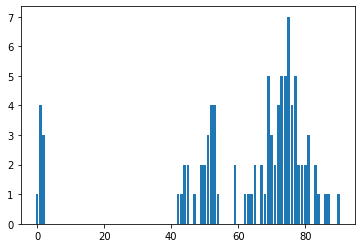

In [20]:
assigned_distance, distribution_difference = get_distances(null_samples, inference_matrix_test)
print("Average assigned distances: {}\n Distribution difference: {}".format(sum(assigned_distance.values())/len(samples), distribution_difference))
from collections import Counter
c = Counter(assigned_distance.values())
plt.bar(c.keys(), c.values())
plt.show()

In [21]:
training_assigned_distance, training_distribution_difference = get_distances(inference_matrix_training, inference_matrix_test)
%store training_avg_assigned_distance
%store training_distribution_difference
sum(training_assigned_distance.values())/len(samples), training_distribution_difference

KeyboardInterrupt: 